In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
from pathlib import Path

In [2]:
ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/')

class uavsar_fp:

    def __init__(self, fp, f1, f2):
        self.fp = fp
        self.f1 = f1
        self.f2 = f2

    def check_dates(self, t1, t2):
        if (self.f1 < t1 + pd.Timedelta('2 days')) & (self.f1 > t1 - pd.Timedelta('2 days')):
            if (self.f2 < t2 + pd.Timedelta('2 days')) & (self.f2 > t2 - pd.Timedelta('2 days')):
                return self

sd_fps = list(ncs_dir.glob('232*.sd.nc'))
sd_fps = [uavsar_fp(fp, pd.to_datetime(fp.name.split('_')[1]), pd.to_datetime(fp.stem.split('_')[2].strip('.sd'))) for fp in sd_fps]

dates = []
for i in [-1, 0, 1]:
    [dates.append(fp.f1 + pd.Timedelta(f'{i} days')) for fp in sd_fps]
    [dates.append(fp.f2 + pd.Timedelta(f'{i} days')) for fp in sd_fps]
dates = np.unique(dates)

In [4]:
xr.open_dataset(sd_fps[0].fp)

<xarray.Dataset>
Dimensions:       (x: 24968, y: 16064, band: 4)
Coordinates:
  * x             (x) float64 -116.4 -116.4 -116.4 ... -115.0 -115.0 -115.0
  * y             (y) float64 44.49 44.49 44.49 44.49 ... 43.59 43.59 43.59
  * band          (band) object 'HV' 'VV' 'HH' 'VH'
    spatial_ref   int64 ...
Data variables:
    cor           (band, y, x) float32 ...
    int           (band, y, x) float32 ...
    unw           (band, y, x) float32 ...
    inc           (y, x) float32 ...
    sd_delta_unw  (band, y, x) float32 ...
    sd_delta_int  (band, y, x) float32 ...
Attributes:
    time1:           2021-01-15
    time2:           2021-01-20
    range_looks:     3
    azimuth_looks:   12
    resolution_m:    6.1744660078619225
    resolution_deg:  5.556e-05
    dSWE:            0.006775000000000017
    dSD:             0.008150000000000004
    mean_density:    283.25

In [130]:
def dissolve_polygon(gdf):
  s_ = gpd.GeoDataFrame(
    geometry=[gdf.unary_union]).explode(
    index_parts=False).reset_index(
    drop=True)
  s_ = s_.set_crs(gdf.crs)
  s_ = gpd.sjoin(s_, gdf, how='left').drop(columns=['index_right'])
  gdf = s_.dissolve(s_.index, aggfunc='first')
  return gdf

/tmp/ipykernel_8379/3484253923.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[:, 'date'] = pd.to_datetime(gdf.date)


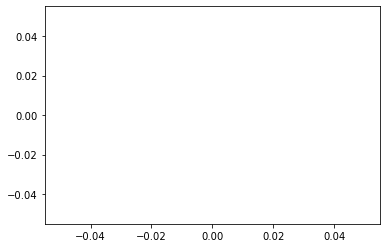

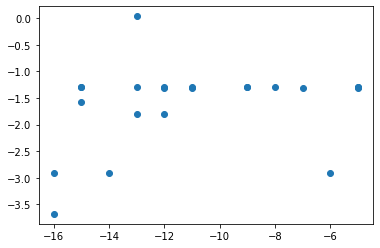

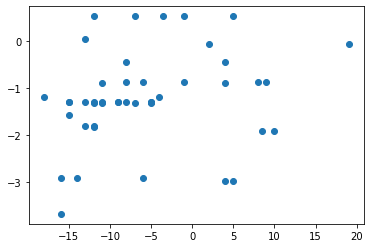

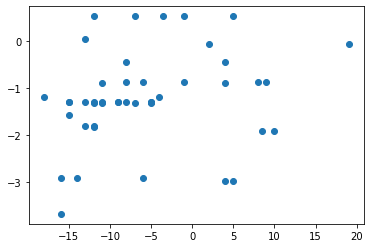

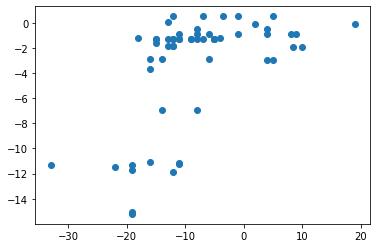

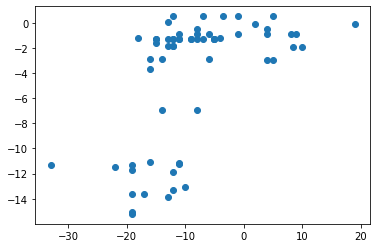

In [192]:
buffer = 0.1
data_var = 'sd_delta_unw'

fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/probes/snowex_depths.csv'
gdf = gpd.read_file(fp, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
gdf.loc[:, 'date'] = pd.to_datetime(gdf.date)
gdf = gdf.loc[gdf['state'] == 'ID']
gdf = gdf.loc[gdf.date.isin(dates)]
gdf = gdf.set_crs(epsg = 4326)
gdf['geometry'] = gdf.to_crs(gdf.estimate_utm_crs()).buffer(buffer)

xs = []
ys = []

for i, fps in enumerate(sd_fps):
    # if i != 1:
    #     continue
    f1s = [fps.f1 + pd.Timedelta(f'{i} days') for i in [-1, 0, 1]]
    f2s = [fps.f2 + pd.Timedelta(f'{i} days') for i in [-1, 0, 1]]
    f1 = gdf.loc[gdf.date.isin(f1s)]
    f2 = gdf.loc[gdf.date.isin(f2s)]
    if len(f1) == 0 or len(f2) == 0:
        continue

    union = f1.overlay(f2, how = 'intersection')
    test = union.dropna(subset = ['depth_1', 'depth_2'])
    if len(test) == 0:
        continue

    test['sd_diff'] = test.depth_2.astype(float) - test.depth_1.astype(float)

    test = dissolve_polygon(test)
    test = test.to_crs(epsg = 4326)
    
    uv = xr.open_dataset(fps.fp)
    if data_var not in uv.data_vars:
        continue
    tol = 0.00090009 # 0.00090009 is ~100 m
    test['unw_sd_diff'] = test['geometry'].apply(lambda row: uv[data_var].sel(band = 'VV').sel(x = row.centroid.x, y = row.centroid.y, method = 'nearest', tolerance = tol).data.reshape([1])[0]*100)

    test['error'] = test['unw_sd_diff'] - test['sd_diff']
    xs.extend(test['sd_diff'])
    ys.extend(test['unw_sd_diff'])
    # test.plot(column = 'error', legend=True)

    # print(len(test))
    # print(test.error.mean())
    plt.scatter(xs, ys)
    plt.show()